In [1]:
import earthaccess
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Download files (Earthdata)

In [2]:
# make sure to login first before downloading files, otherwise get none
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 08/18/2023
Using .netrc file for EDL


In [18]:
# First approach, search only
results = earthaccess.search_data(
    short_name='OSCAR_L4_OC_FINAL_V2.0',
    cloud_hosted=True,
    bounding_box = (60, 5, 80, 25),
    temporal=("2007-01", "2020-12")
)

Granules found: 5084



KeyboardInterrupt



In [4]:
granule = earthaccess.granule_query().short_name("SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205").temporal(
'2000-01', '2000-02').get(1)
file = earthaccess.download(granule, './')


 Getting 1 granules, approx download size: 0.0 GB


SUBMITTING | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
ssh = xr.open_dataset('ssh_grids_v2205_2000010212.nc')
ssh

<xarray.Dataset>
Dimensions:      (Longitude: 2160, nv: 2, Latitude: 960, Time: 1)
Coordinates:
  * Longitude    (Longitude) float32 0.08333 0.25 0.4167 ... 359.6 359.8 359.9
  * Latitude     (Latitude) float32 -79.92 -79.75 -79.58 ... 79.58 79.75 79.92
  * Time         (Time) datetime64[ns] 2000-01-02T12:00:00
Dimensions without coordinates: nv
Data variables:
    Lon_bounds   (Longitude, nv) float32 ...
    Lat_bounds   (Latitude, nv) float32 ...
    Time_bounds  (Time, nv) datetime64[ns] ...
    SLA          (Time, Latitude, Longitude) float32 ...
    SLA_ERR      (Time, Latitude, Longitude) float32 ...
Attributes: (12/21)
    Conventions:            CF-1.6
    ncei_template_version:  NCEI_NetCDF_Grid_Template_v2.0
    Institution:            Jet Propulsion Laboratory
    geospatial_lat_min:     -79.916664
    geospatial_lat_max:     79.916664
    geospatial_lon_min:     0.083333336
    ...                     ...
    version_number:         2205
    Data_Pnts_Each_Sat:     {"16": 748097, "1002": 620491}
    source_version:         commit ad8fdfbffc5581946ae8e9ea13699e2d6dcadba9
    SLA_Global_MEAN:        0.0006811716468230787
    SLA_Global_STD:         0.08649267762275449
    latency:                final

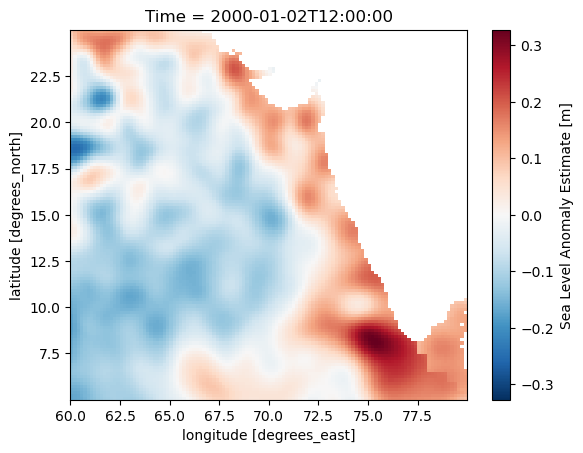

In [6]:
ssh.sel(Longitude=slice(60, 80), Latitude=slice(5, 25)).isel(Time=0)['SLA'].plot.imshow()

In [3]:
# Second approach

def download_granules_by_year(year):
    granules = []
    count = 1
    date = pd.date_range(f'{year}-01-01', f'{year+1}-02-01', freq='M')
    for i in range(len(date)-1):
        # get all days
        granule = earthaccess.granule_query().short_name("SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205").temporal(f'{date[i].year}-{date[i].month}',
                                                                                            f'{date[i+1].year}-{date[i+1].month}').get(32)
        print(count, end=" ")
        count +=1
        granules.extend(granule)
    
    # from precomputed calculations, the bounding box indices are:
    lat1, lat2, lon1, lon2 = 379, 459, 240, 320
    print(len(granules))
    files = earthaccess.download(granules, 'surface_currents/')
    
    # combine files
    data = xr.open_mfdataset(f'surface_currents/oscar_currents_final_{year}*.nc').isel(latitude=slice(lat1, lat2+1), longitude=slice(lon1, lon2+1))
    data.to_netcdf(f'surface_currents/combined/{year}-processed.nc')
    
    # delete file chunks by running 
    # rm -rf surface_currents/oscar_currents_final_[YEAR]*.nc in command line
    

In [11]:
for i in [2020]:
    download_granules_by_year(i)

1 2 3 4 5 6 7 8 9 10 11 12 377
 Getting 377 granules, approx download size: 0.0 GB


SUBMITTING | :   0%|          | 0/377 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/377 [00:00<?, ?it/s]

File oscar_currents_final_20201201.nc already downloaded


COLLECTING | :   0%|          | 0/377 [00:00<?, ?it/s]

In [16]:
# save variable in case jupyter notebook lost connection
import pickle
with open('granules.pkl', 'wb') as f:
    pickle.dump(granules, f)

In [17]:
with open('granules.pkl', 'rb') as f:
    granule = pickle.load(f)

In [52]:
xr.open_mfdataset('surface_currents/oscar_currents_final_200001*.nc')

<xarray.Dataset>
Dimensions:  (latitude: 719, longitude: 1440, time: 31)
Coordinates:
    lat      (latitude) float64 dask.array<chunksize=(719,), meta=np.ndarray>
    lon      (longitude) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-31 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    v        (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 dask.array<chunksize=(1, 1440, 719), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

In [7]:
f1 = xr.open_dataset('surface_currents/oscar_currents_final_20000102.nc')

In [43]:
xr.open_dataset('surface_currents/oscar_currents_final_20071019.nc')

OSError: [Errno -101] NetCDF: HDF error: '/home/jovyan/surface_currents/oscar_currents_final_20071019.nc'

In [9]:
f1 = f1.transpose('time', 'latitude', 'longitude')

In [10]:
lat_vals = f1.lat.values
lon_vals = f1.lon.values

In [11]:
lat1 = np.where(lat_vals==5)[0][0]
lat2 = np.where(lat_vals==25)[0][0]
lon1 = np.where(lon_vals==60)[0][0]
lon2 = np.where(lon_vals==80)[0][0]

In [12]:
print(lat1, lat2, lon1, lon2)

379 459 240 320


In [11]:
f1['ug'].sel(longitude=slice(lon1, lon2+1),latitude=slice(lat1, lat2+1))

<xarray.DataArray 'ug' (time: 1, latitude: 81, longitude: 81)>
array([[[ 0.073498,  0.025308, ..., -0.699962, -0.733245],
        [ 0.031701,  0.010567, ..., -0.570953, -0.599683],
        ...,
        [-0.26141 , -0.185267, ...,       nan,       nan],
        [-0.212059, -0.109819, ...,       nan,       nan]]])
Coordinates:
    lat      (latitude) float64 5.0 5.25 5.5 5.75 6.0 ... 24.25 24.5 24.75 25.0
    lon      (longitude) float64 60.0 60.25 60.5 60.75 ... 79.25 79.5 79.75 80.0
  * time     (time) object 2000-01-01 00:00:00
Dimensions without coordinates: latitude, longitude
Attributes:
    long_name:      zonal geostrophic surface current
    standard_name:  geostrophic_eastward_sea_water_velocity
    units:          m s-1
    valid_min:      -3.0
    valid_max:      3.0
    depth:          15m
    comment:        Geostrophic velocities calculated from absolute dynamic t...
    source:         SSH source: CMEMS SSALTO/DUACS SEALEVEL_GLO_PHY_L4_MY_008...

In [59]:
granules[0].data_links()[0].split('/')[-1]

'oscar_currents_final_20000101.nc'

In [8]:
y = xr.open_dataset('surface_currents/combined/2019-processed.nc')

In [9]:
y

<xarray.Dataset>
Dimensions:  (latitude: 81, longitude: 81, time: 362)
Coordinates:
    lat      (latitude) float64 ...
    lon      (longitude) float64 ...
  * time     (time) object 2019-01-01 00:00:00 ... 2019-12-31 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 ...
    v        (time, longitude, latitude) float64 ...
    ug       (time, longitude, latitude) float64 ...
    vg       (time, longitude, latitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2019-01-01T00:00:00
    time_coverage_end:          2019-01-01T23:59:59
    date_created:               2022-01-14

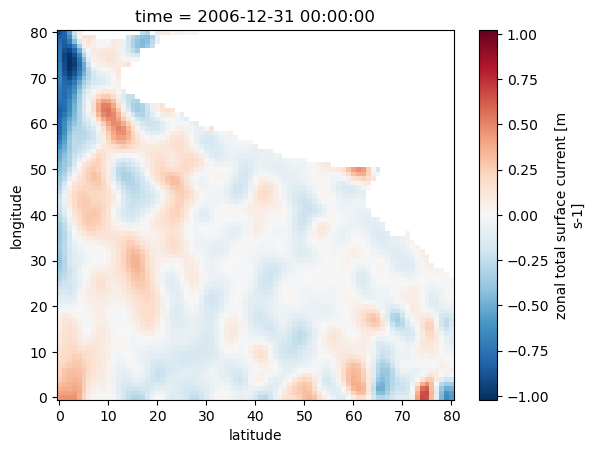

In [17]:
y['u'].isel(time=-1).plot.imshow()

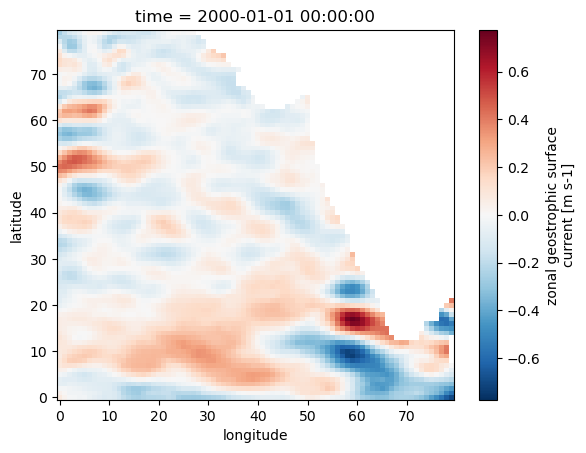

In [12]:
p = f1['ug'].isel(time=0).sel(longitude=slice(lon1, lon2),latitude=slice(lat1, lat2)).plot.imshow()

In [90]:
t = p.figure

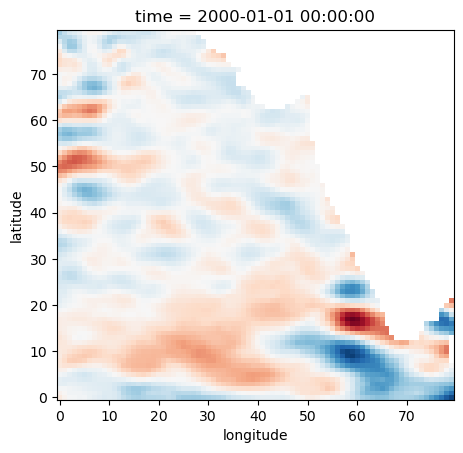

In [91]:
t

In [100]:
t1 = t.axes[0]

In [114]:
t1.axis('off')
t1.set_title('')

Text(0.5, 1.0, '')

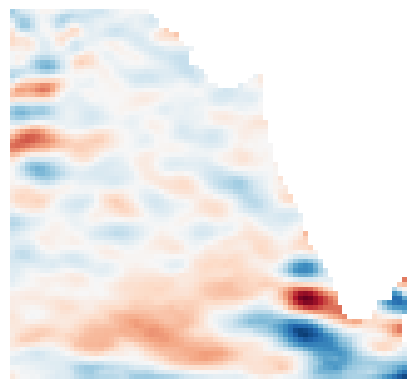

In [115]:
t

In [93]:
t.savefig('2.png')

In [94]:
plt.savefig('2p.png')

<Figure size 640x480 with 0 Axes>

In [49]:
t.axes[1]

<Axes: label='<colorbar>', ylabel='zonal geostrophic surface\ncurrent [m s-1]'>

In [15]:
f1['vg'].sel(lat=f1.lat.to_index().get_indexer())

TypeError: get_indexer() missing 1 required positional argument: 'target'

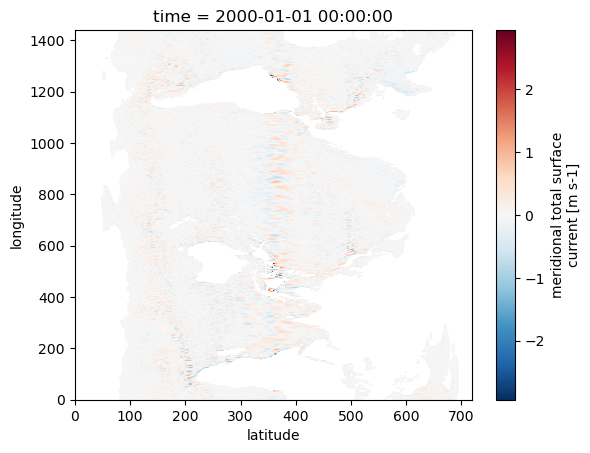

In [12]:
f1['v'].isel(time=0).plot.imshow()

In [111]:
f1

<xarray.Dataset>
Dimensions:  (latitude: 719, longitude: 1440, time: 1)
Coordinates:
    lat      (latitude) float64 -89.75 -89.5 -89.25 -89.0 ... 89.25 89.5 89.75
    lon      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) object 2000-01-01 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 ...
    v        (time, latitude, longitude) float64 ...
    ug       (time, latitude, longitude) float64 ...
    vg       (time, latitude, longitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

In [2]:
# run this line before plotting!
combined  = xr.open_mfdataset('surface_currents/combined/*.nc').transpose('time', 'latitude', 'longitude')

In [3]:
combined['time'] = combined.indexes['time'].to_datetimeindex()

/tmp/ipykernel_41/3373087629.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  combined['time'] = combined.indexes['time'].to_datetimeindex()


In [4]:
combined

<xarray.Dataset>
Dimensions:  (latitude: 81, longitude: 81, time: 7671)
Coordinates:
    lat      (latitude) float64 dask.array<chunksize=(81,), meta=np.ndarray>
    lon      (longitude) float64 dask.array<chunksize=(81,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 dask.array<chunksize=(366, 81, 81), meta=np.ndarray>
    v        (time, latitude, longitude) float64 dask.array<chunksize=(366, 81, 81), meta=np.ndarray>
    ug       (time, latitude, longitude) float64 dask.array<chunksize=(366, 81, 81), meta=np.ndarray>
    vg       (time, latitude, longitude) float64 dask.array<chunksize=(366, 81, 81), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

In [9]:
# make sure that all days are covered
all_days = np.array([s.to_datetime64() for s in pd.date_range('2000/1/1', '2020/12/31')])

#print out days that are not in the dataset, should be none
np.setdiff1d(all_days, combined.time.values)

array([], dtype='datetime64[ns]')

In [5]:
# this does not work
combined_rechunk = xr.unify_chunks(combined)

In [13]:
# unify all chunks over the time dimension
combined.chunk({'time': all_days.shape[0]}).to_zarr('surface_currents/surface_currents.zarr')

# Masking

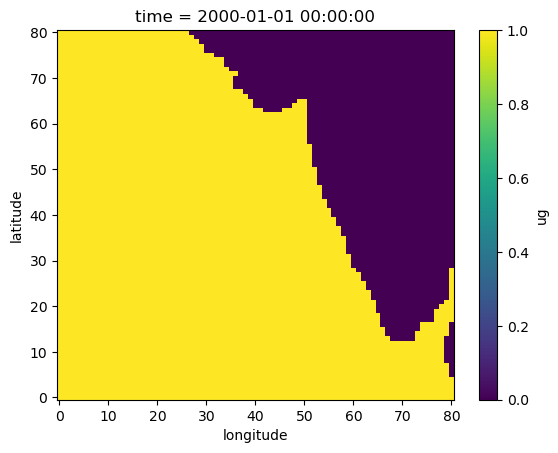

In [25]:
f1['ug'].isel(time=0).sel(longitude=slice(lon1, lon2+1),latitude=slice(lat1, lat2+1)).notnull().plot.imshow()

In [26]:
f1['ug'].isel(time=0).sel(longitude=slice(lon1, lon2+1),latitude=slice(lat1, lat2+1)).notnull().to_dataframe()

lat    lon                 time     ug
latitude longitude                                         
0        0           5.0  60.00  2000-01-01 00:00:00   True
         1           5.0  60.25  2000-01-01 00:00:00   True
         2           5.0  60.50  2000-01-01 00:00:00   True
         3           5.0  60.75  2000-01-01 00:00:00   True
         4           5.0  61.00  2000-01-01 00:00:00   True
...                  ...    ...                  ...    ...
80       76         25.0  79.00  2000-01-01 00:00:00  False
         77         25.0  79.25  2000-01-01 00:00:00  False
         78         25.0  79.50  2000-01-01 00:00:00  False
         79         25.0  79.75  2000-01-01 00:00:00  False
         80         25.0  80.00  2000-01-01 00:00:00  False

[6561 rows x 4 columns]

In [27]:
p = f1['ug'].isel(time=0).sel(longitude=slice(lon1, lon2+1),latitude=slice(lat1, lat2+1)).notnull().to_dataframe()

In [28]:
mask = p.reset_index().drop(columns=['latitude', 'longitude', 'time'])

In [31]:
m = mask[mask['ug']==True]

In [32]:
m.to_csv('mask.csv')

# Download data (Corpernicus)

In [2]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'satellite-sea-level-global',
    {
        'version': 'vDT2021',
        'format': 'zip',
        'variable': 'daily',
        'year': '2000',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
    },
    'download.zip')

2023-06-28 11:59:48,471 INFO Welcome to the CDS
2023-06-28 11:59:48,472 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2023-06-28 11:59:48,801 INFO Request is queued
2023-06-28 11:59:49,981 INFO Request is running
2023-06-28 12:01:44,013 INFO Request is completed
2023-06-28 12:01:44,013 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data5/dataset-satellite-sea-level-global-fcabb865-cefe-44da-9f2c-82b642a272f8.zip to download.zip (3.3G)
2023-06-28 12:06:55,598 INFO Download rate 10.9M/s     


Result(content_length=3565181293,content_type=application/zip,location=https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data5/dataset-satellite-sea-level-global-fcabb865-cefe-44da-9f2c-82b642a272f8.zip)

In [3]:
import shutil
shutil.unpack_archive('download.zip', 'copernicus/')

# Interpolation

In [2]:
cop = xr.open_mfdataset('copernicus/*.nc')

In [6]:
cop

<xarray.Dataset>
Dimensions:         (time: 366, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time            (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds        (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds        (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

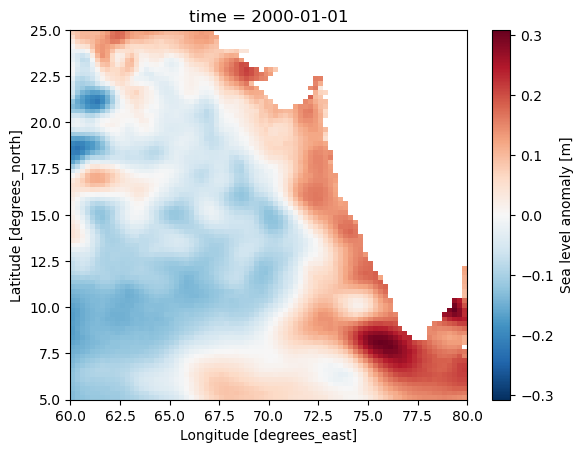

In [8]:
cop.sla.isel(time=0).sel(latitude=slice(5, 25), longitude=slice(60,80)).plot.imshow()

In [5]:
wind = xr.open_dataset('era5/wind.nc')
wind

<xarray.Dataset>
Dimensions:  (lon: 81, lat: 81, time: 184104)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 79.25 79.5 79.75 80.0
  * lat      (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 6.0 5.75 5.5 5.25 5.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T23:00:00
Data variables:
    u_wind   (time, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts
    title:        ERA5 forecasts

In [6]:
wind_grid = wind['u_wind'].isel(time=0)
wind_grid

<xarray.DataArray 'u_wind' (lat: 81, lon: 81)>
array([[-1.727875, -2.138031, -2.662445, ..., -1.995453, -1.877289, -1.513031],
       [-1.276703, -1.715179, -2.27475 , ..., -1.904633, -1.76889 , -1.828461],
       [-1.014008, -1.46225 , -2.000336, ..., -1.978851, -2.052094, -2.295258],
       ...,
       [-4.232758, -4.076508, -3.838226, ..., -3.686859, -5.449554, -6.380219],
       [-4.070648, -3.918304, -3.722015, ..., -5.857758, -6.766937, -7.350922],
       [-3.894867, -3.705414, -3.529633, ..., -6.575531, -7.311859, -7.316742]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 79.25 79.5 79.75 80.0
  * lat      (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 6.0 5.75 5.5 5.25 5.0
    time     datetime64[ns] 2000-01-01
Attributes:
    standard_name:   eastward_wind
    units:           m s**-1
    long_name:       10 metre U wind component
    nameECMWF:       10 metre U wind component
    shortNameECMWF:  10u
    nameCDM:         10_metre_U_wind_component_surface
    product_type:    analysis

In [22]:
cop_cropped = cop.sla.sel(latitude=slice(4, 26), longitude=slice(59,81)).rename({"latitude": "lat", "longitude": "lon"})

In [33]:
cop_interp_linear = cop_cropped.interp_like(wind_grid)
cop_interp_linear

<xarray.DataArray 'sla' (time: 366, lat: 81, lon: 81)>
dask.array<dask_aware_interpnd, shape=(366, 81, 81), dtype=float64, chunksize=(1, 81, 81), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * lat      (lat) float32 25.0 24.75 24.5 24.25 24.0 ... 6.0 5.75 5.5 5.25 5.0
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 79.25 79.5 79.75 80.0
Attributes:
    ancillary_variables:  err_sla
    comment:              The sea level anomaly is the sea surface height abo...
    grid_mapping:         crs
    long_name:            Sea level anomaly
    standard_name:        sea_surface_height_above_sea_level
    units:                m

Text(0.5, 1.0, 'original')

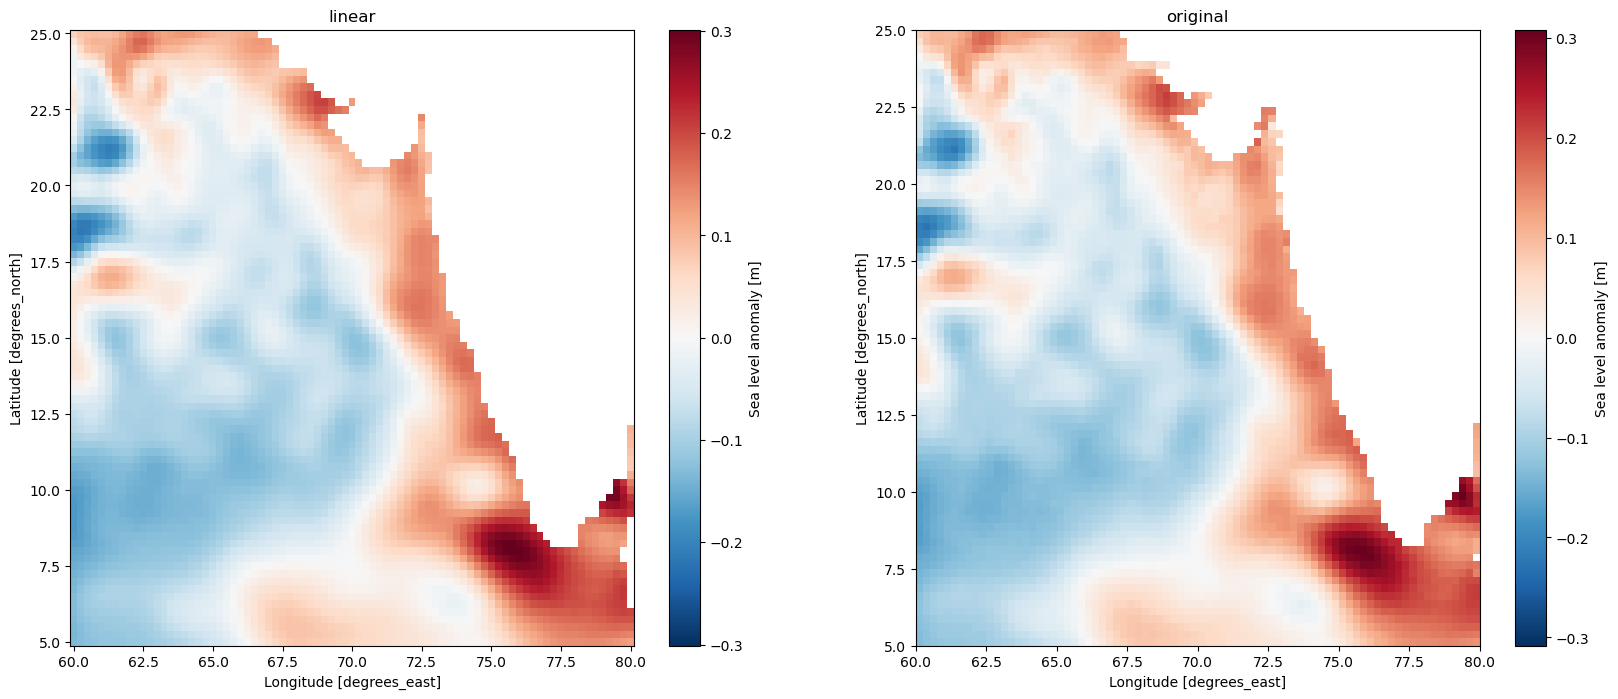

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
cop_interp_linear.isel(time=0).plot.imshow(ax = ax1)
cop.sla.isel(time=0).sel(latitude=slice(5, 25), longitude=slice(60,80)).plot.imshow(ax=ax2)
ax1.set_title('linear')
ax2.set_title('original')

Text(0.5, 1.0, 'original')

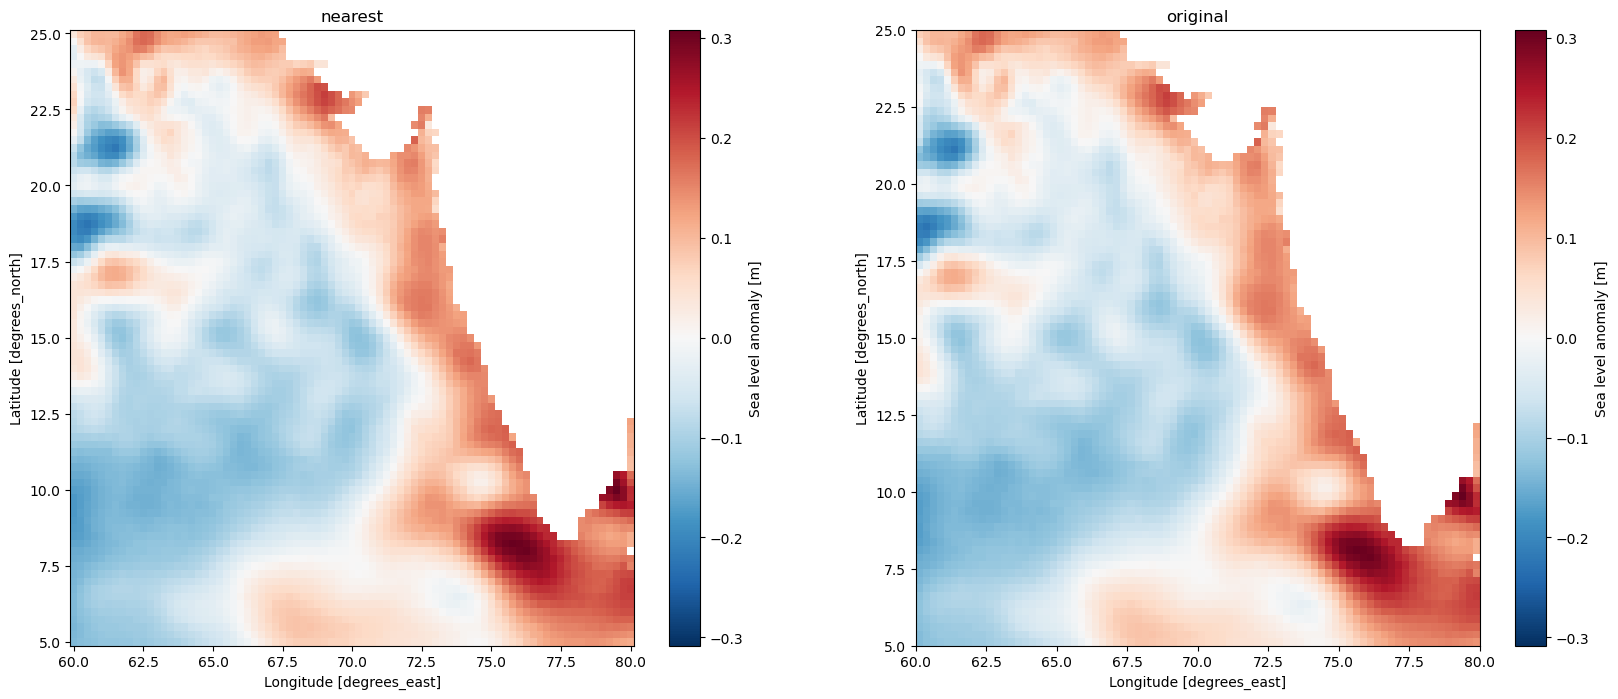

In [34]:
cop_interp_nearest = cop_cropped.interp_like(wind_grid, method='nearest')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
cop_interp_nearest.isel(time=0).plot.imshow(ax = ax1)
cop.sla.isel(time=0).sel(latitude=slice(5, 25), longitude=slice(60,80)).plot.imshow(ax=ax2)
ax1.set_title('nearest')
ax2.set_title('original')

Text(0.5, 1.0, 'original')

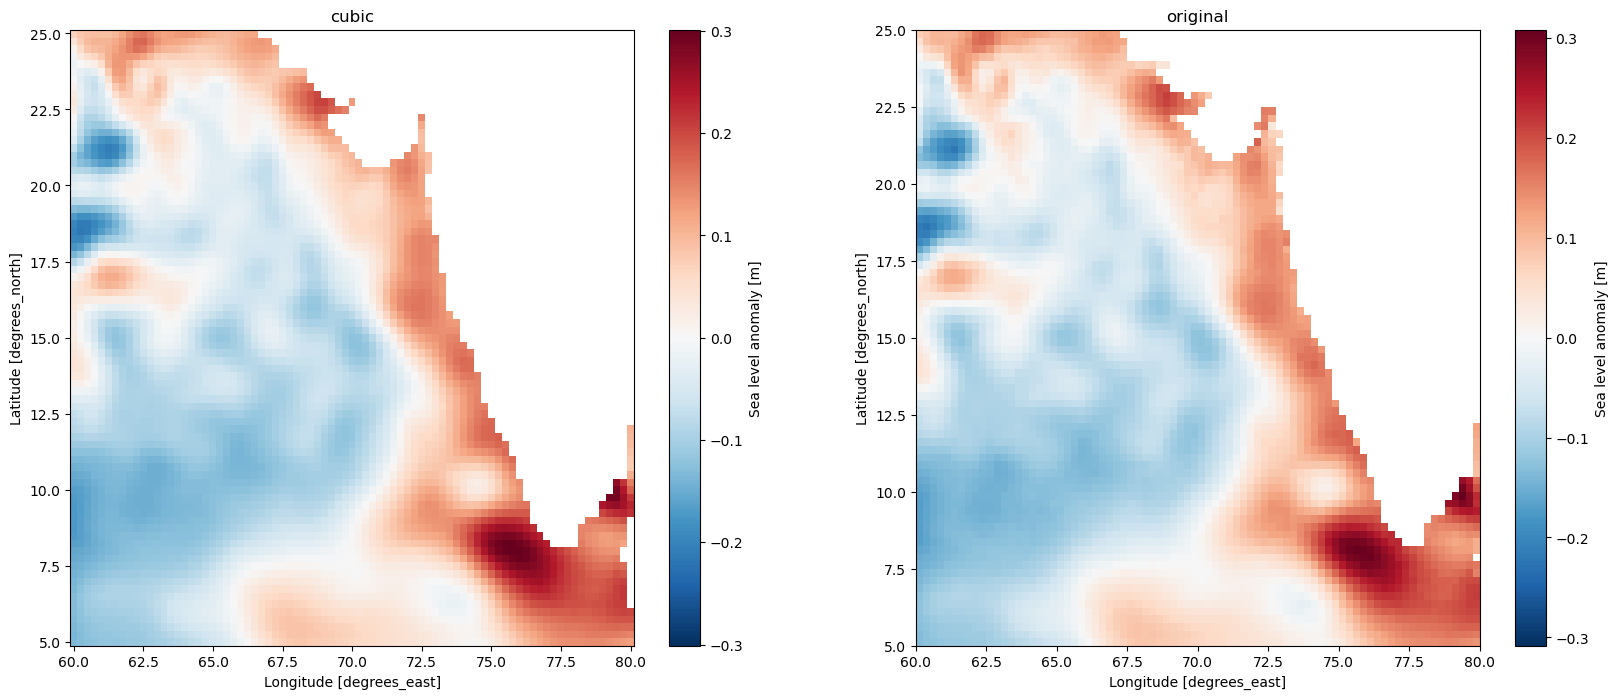

In [40]:
cop_interp_cubic = cop_cropped.interp_like(wind_grid, method='slinear')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
cop_interp_cubic.isel(time=0).plot.imshow(ax = ax1)
cop.sla.isel(time=0).sel(latitude=slice(5, 25), longitude=slice(60,80)).plot.imshow(ax=ax2)
ax1.set_title('cubic')
ax2.set_title('original')

In [41]:
xr.open_dataset('cop_sla/2000.nc')

<xarray.Dataset>
Dimensions:    (time: 366, latitude: 80, longitude: 80)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * latitude   (latitude) float32 5.125 5.375 5.625 5.875 ... 24.38 24.62 24.88
  * longitude  (longitude) float32 60.12 60.38 60.62 60.88 ... 79.38 79.62 79.88
Data variables:
    sla        (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

NameError: name 'xr' is not defined